In [1]:
import json
import psycopg2
import time
import pandas as pd
from datetime import datetime
import numpy as np
import math
import pickle
import warnings
import os
import pandas.io.sql as sqlio
# from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
conn = psycopg2.connect(
    host='hp-dev-db-12sep.cgitnjqny0tw.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='hp_read_user',
    password='hp_@_2023_321',
    database='postgres'
)

<ipython-input-3-6ff04d6ea781>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  e=pd.read_sql(q,conn)


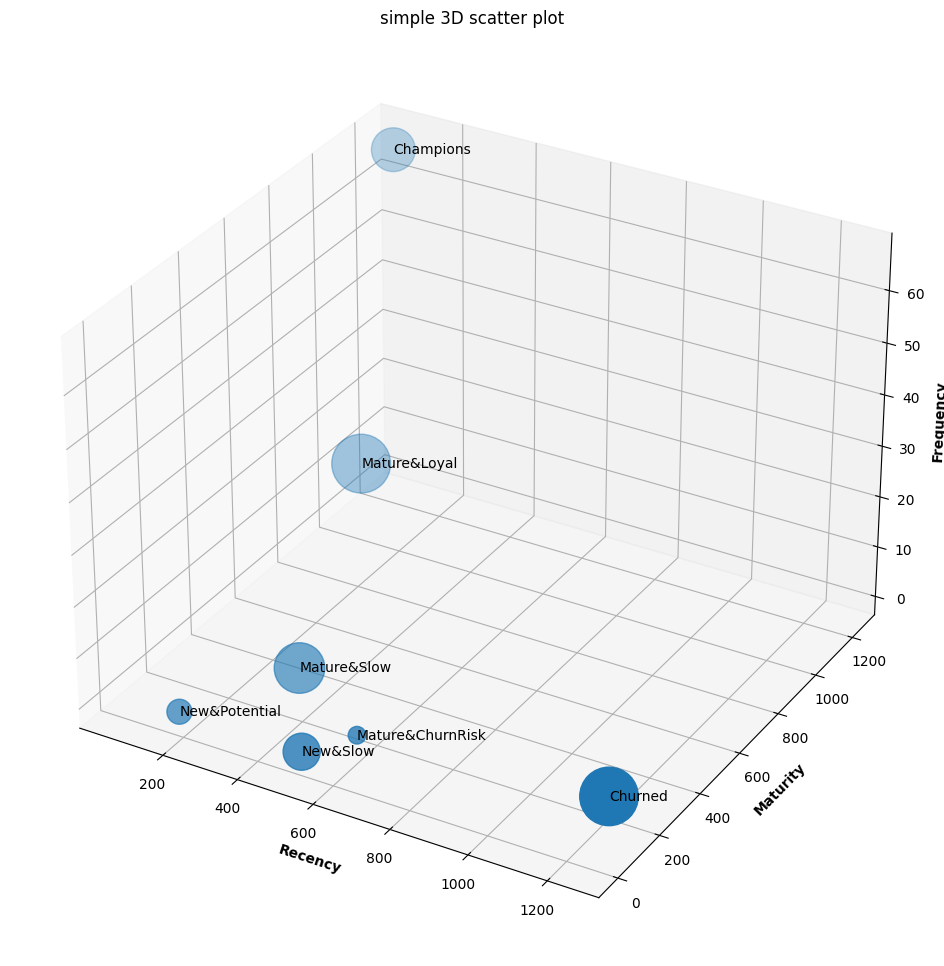

In [3]:
q=('''

   SELECT created as order_date, order_id as order_iD, order_amount as order_amount, user_id as user_id
FROM public.sales_userorderdata
WHERE
order_status='Delivered';

''')


e=pd.read_sql(q,conn)
# e = e[e['order_date'] >= '2023-01-01']
# e = e[e['order_date'] <= '2023-06-30']
e['order_date']=e['order_date'].dt.date
e['order_date']=pd.to_datetime(e['order_date'])
e['user_id']=e['user_id']
e['order_amount']=e['order_amount']



#Delta Columns
e['DeltaDaysinOrders']=(e.groupby('user_id').order_date.shift() - e.order_date).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)

x1=e.groupby('user_id').agg(
        LastDate=pd.NamedAgg(column='order_date', aggfunc= 'max'),
        FirstDate=pd.NamedAgg(column='order_date', aggfunc='min'),
        Frequency=pd.NamedAgg(column='order_id', aggfunc='count'),
        AOV=pd.NamedAgg(column='order_amount', aggfunc='sum'),
        MeanDaysDelta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
        MeanOVDelta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean')

    ).reset_index()


globalmaxdate=e['order_date'].max()
x1['Recency']=globalmaxdate-x1['LastDate']
x1['Recency']=x1['Recency'].dt.days.abs()
x1['ActivatedQuater']=x1['FirstDate'].dt.to_period('Q')
x1['MaturityAge']=x1['LastDate']-x1['FirstDate']
x1['MaturityAge']=x1['MaturityAge'].dt.days.abs()
x1['MeanDaysDelta']=x1['MeanDaysDelta'].fillna(0)
x1['MeanOVDelta']=x1['MeanOVDelta'].fillna(0)
x1['FrequencyperDeltaDays']=x1['Frequency']/x1['MeanDaysDelta']


r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
x1['r_score'] = x1['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
x1['f2d_score'] = x1['Frequency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
x1['AOV_score'] = x1['AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
x1['m_score'] = x1['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
x1['DelAOV'] = x1['MeanOVDelta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
x1['SumScore'] = x1['r_score'] + x1['f2d_score'] + x1['m_score'] + x1['AOV_score']+ x1['DelAOV']

def CohortLables(df):
    if df['SumScore'] >= 18:
        return 'Champions'
    elif ((df['m_score'] <=1) and (df['SumScore'] >= 10)and (df['SumScore'] < 18) and (df['r_score'] >1)):
        return 'New&Potential'
    elif ((df['m_score'] >1) and (df['SumScore'] >= 14)and (df['SumScore'] < 18)and (df['r_score'] >1)):
        return 'Mature&Loyal'
    elif ((df['m_score'] >1) and (df['SumScore'] >= 10)and (df['SumScore'] < 14)and (df['r_score'] >1)):
        return 'Mature&Slow'

    elif ((df['m_score'] <=1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
        return 'New&Slow'
    elif ((df['m_score'] >1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
        return 'Mature&ChurnRisk'
    else:
        return 'Churned'
# Create a new variable RFM_Level
x1['CohortLabel'] = x1.apply(CohortLables, axis=1)



segstats=x1.groupby(
   'CohortLabel'
).agg(
       Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
       Recency=pd.NamedAgg(column='Recency', aggfunc='mean'),
       Frequency=pd.NamedAgg(column='Frequency', aggfunc='mean'),
       AOV=pd.NamedAgg(column='AOV', aggfunc='mean'),
       MeanDaysDelta=pd.NamedAgg(column='MeanDaysDelta', aggfunc='mean'),
       MeanOVDelta=pd.NamedAgg(column='MeanOVDelta', aggfunc='mean'),
      FrequencyperDeltaDays=pd.NamedAgg(column='FrequencyperDeltaDays', aggfunc='mean'),
    Maturity=pd.NamedAgg(column='MaturityAge', aggfunc='mean')

 ).reset_index()

segstats['OrderCountMix']=segstats['Frequency']/segstats['Frequency'].sum()
segstats['UsersMix']=segstats['Users']/segstats['Users'].sum()


#Visualization of cohorts with key parameters as axises
fig = plt.figure(figsize = (25, 12))
ax = plt.axes(projection ="3d")
size=segstats['Users']*.25
# Creating plot
ax.scatter3D(segstats['Recency'], segstats['Maturity'],segstats['Frequency'], s=size)
plt.title("simple 3D scatter plot")
ax.set_xlabel('Recency', fontweight ='bold')
ax.set_ylabel('Maturity', fontweight ='bold')
ax.set_zlabel('Frequency', fontweight ='bold')
for i in range(len(segstats)):
     ax.text(segstats['Recency'][i],
               segstats['Maturity'][i],
             segstats['Frequency'][i],
               segstats['CohortLabel'][i],
               horizontalalignment='left',
               rotation=25, wrap=True,
               verticalalignment='center',
               size='medium', color='black')



##traxn level insights Trxn Dist by Acquisition months
e2=e.merge(x1[['user_id','MeanDaysDelta','MeanOVDelta','LastDate','FirstDate']], left_on='user_id', right_on='user_id')
e2['AcqMonth']=e2['FirstDate'].dt.strftime('%Y-%m')
e2['OrderMonth']=e2['order_date'].dt.strftime('%Y-%m')

x2=e2.groupby(
   ['AcqMonth','OrderMonth']
).agg(
       Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        ).unstack()

x2=x2.reset_index()

In [4]:

e2.head()

,order_date,order_id,order_amount,user_id,DeltaDaysinOrders,DeltaOrderValues,MeanDaysDelta,MeanOVDelta,LastDate,FirstDate,AcqMonth,OrderMonth
0,2023-01-25,RPRSAOH76694,183.00,9718,NaN,NaN,227.422222,-0.338148,2023-08-07,2019-04-03,2019-04,2023-01
1,2019-11-15,336325-146847,622.20,9718,1167.0,-439.20,227.422222,-0.338148,2023-08-07,2019-04-03,2019-04,2019-11
2,2019-12-17,337837-155414,79.90,9718,32.0,542.30,227.422222,-0.338148,2023-08-07,2019-04-03,2019-04,2019-12
3,2020-09-19,RPRSA3V19485,613.00,9718,277.0,-533.10,227.422222,-0.338148,2023-08-07,2019-04-03,2019-04,2020-09
4,2020-04-25,387162-227063,175.73,9718,147.0,437.27,227.422222,-0.338148,2023-08-07,2019-04-03,2019-04,2020-04


Getting weeks from the order date column

Considering the DeltaDaysInOrders and order_date column only for retention analysis.

In [5]:
e2['week'] = e2['order_date'].dt.strftime('%Y-w%U')

In [6]:
print(e2)

       order_date       order_id  order_amount  user_id  DeltaDaysinOrders  \
0      2023-01-25   RPRSAOH76694        183.00     9718                NaN   
1      2019-11-15  336325-146847        622.20     9718             1167.0   
2      2019-12-17  337837-155414         79.90     9718               32.0   
3      2020-09-19   RPRSA3V19485        613.00     9718              277.0   
4      2020-04-25  387162-227063        175.73     9718              147.0   
...           ...            ...           ...      ...                ...   
502834 2019-04-09   315859-89088        435.10    10529                NaN   
502835 2022-12-11   RPRSA1D64451        177.00    26300                NaN   
502836 2019-06-20  316182-105469       1596.30    15964                NaN   
502837 2023-01-06   DRGSAE920172       3339.00    52912                NaN   
502838 2020-03-18  537252-189373        851.79    25525                NaN   

        DeltaOrderValues  MeanDaysDelta  MeanOVDelta   LastDate

In [7]:

e2['week'].value_counts()

2021-w16    3928
2021-w14    3783
2021-w17    3686
2021-w15    3671
2021-w18    3329
            ... 
2019-w15    1154
2019-w52     698
2021-w00     636
2022-w00     287
2023-w37     274
Name: week, Length: 236, dtype: int64

In [8]:

e2['DeltaDaysinOrders'].max()

1619.0

In [9]:

e2['DeltaDaysinOrders'].min()

0.0

Now, we are finding out the group of people for every week falling under these bins.

Eg: In 2019-w19: there are 139 people who have ordered within 42 days of their previous order. Now similarly, for every week, we have counts of people in every bin, and this is what is being done here.

In [10]:
e3 = e2.copy()
e3.dropna()
e3=e3.sort_values(by='week',ascending=True)
bins = [0.0, 42.0, 82.0, 122.0, 163.0, 204.0, 244.0, 284.0, 325.0, 366.0, 406.0, 810.0, 1214.0, 1619.0]
e3['Bin'] = pd.cut(e3['DeltaDaysinOrders'], bins, right=False)
result = e3.groupby(['week', 'Bin']).size().unstack(fill_value=0)
all_weeks = pd.Series(e3['week'].unique(), name='week')
result = result.reindex(all_weeks, fill_value=0)

In [11]:

result

Bin,"[0.0, 42.0)","[42.0, 82.0)","[82.0, 122.0)","[122.0, 163.0)","[163.0, 204.0)","[204.0, 244.0)","[244.0, 284.0)","[284.0, 325.0)","[325.0, 366.0)","[366.0, 406.0)","[406.0, 810.0)","[810.0, 1214.0)","[1214.0, 1619.0)"
week,,,,,,,,,,,,,
2019-w13,132,113,82,75,77,47,65,68,48,42,165,25,112
2019-w14,155,96,98,74,52,70,62,56,67,57,167,14,153
2019-w15,174,92,77,71,73,57,50,55,52,56,153,15,111
2019-w16,193,100,83,71,80,63,56,53,47,42,163,22,121
2019-w17,231,109,98,81,77,71,68,64,64,52,159,15,131
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-w33,1115,168,66,22,14,25,22,8,11,2,16,69,21
2023-w34,1222,207,65,52,43,33,16,4,9,6,14,92,34
2023-w35,1421,182,68,17,11,7,4,1,0,3,3,49,9


In [12]:
result = result[:-7]

In [14]:
result

,0 - 42 Days,42 - 82 Days,82 - 122 Days,122 - 163 Days,163 - 204 Days,204 - 244 Days,244 - 284 Days,284 - 325 Days,325 - 366 Days,366 - 406 Days,406 - 810 Days,810 - 1214 Days,1214 - 1619 Days
week,,,,,,,,,,,,,
2019-w13,132,113,82,75,77,47,65,68,48,42,165,25,112
2019-w14,155,96,98,74,52,70,62,56,67,57,167,14,153
2019-w15,174,92,77,71,73,57,50,55,52,56,153,15,111
2019-w16,193,100,83,71,80,63,56,53,47,42,163,22,121
2019-w17,231,109,98,81,77,71,68,64,64,52,159,15,131
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-w26,976,249,45,34,8,6,7,20,15,9,49,158,15
2023-w27,1300,228,65,45,28,21,2,1,0,1,28,156,28
2023-w28,1398,234,37,26,10,5,0,1,0,2,8,128,7


In [13]:
call_list = []

for i in range(len(result.columns.tolist())):
    lst = result.columns.tolist()
    x = str(lst[i])
    a = (x.split(",")[0])[1:-2]
    b = (x.split(",")[1])[1:-3]
    x = a + " - " + b + " Days"
    call_list.append(x)
result.columns = call_list

In [15]:
new_result = result.copy()
new_result['Total Number of Users'] = new_result.sum(axis=1)

<Figure size 500x500 with 0 Axes>

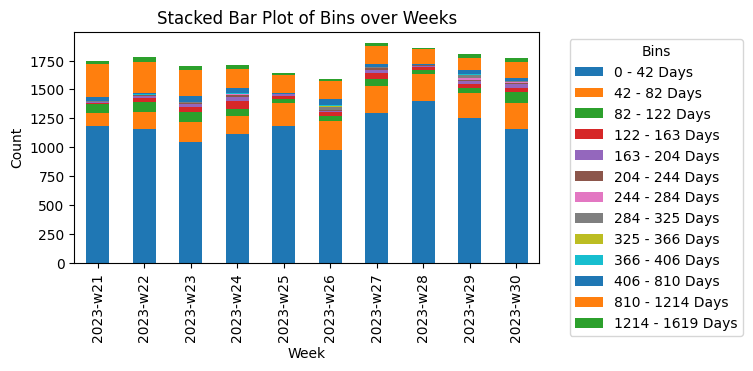

In [43]:
# result.set_index('Bin', inplace=True)
plt.figure(figsize=(5,5))
x = result.tail(10)
ax = x.plot(kind='bar', stacked=True, figsize=(6,3))

ax.legend(title='Bins', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Week')
plt.ylabel('Count')
plt.title('Stacked Bar Plot of Bins over Weeks')

plt.show()

In [17]:
delta_result = new_result.diff(axis=0)

In [31]:
delta_result['Total Number of Users'].min()

-1731.0

In [32]:
delta_result[delta_result['Total Number of Users']==-1731.0]

,0 - 42 Days,42 - 82 Days,82 - 122 Days,122 - 163 Days,163 - 204 Days,204 - 244 Days,244 - 284 Days,284 - 325 Days,325 - 366 Days,366 - 406 Days,406 - 810 Days,810 - 1214 Days,1214 - 1619 Days,Total Number of Users
week,,,,,,,,,,,,,,
2022-w00,-810.0,-461.0,-202.0,-131.0,-20.0,-14.0,-16.0,-12.0,-3.0,-2.0,-55.0,-5.0,0.0,-1731.0


In [18]:
delta_result

,0 - 42 Days,42 - 82 Days,82 - 122 Days,122 - 163 Days,163 - 204 Days,204 - 244 Days,244 - 284 Days,284 - 325 Days,325 - 366 Days,366 - 406 Days,406 - 810 Days,810 - 1214 Days,1214 - 1619 Days,Total Number of Users
week,,,,,,,,,,,,,,
2019-w13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-w14,23.0,-17.0,16.0,-1.0,-25.0,23.0,-3.0,-12.0,19.0,15.0,2.0,-11.0,41.0,70.0
2019-w15,19.0,-4.0,-21.0,-3.0,21.0,-13.0,-12.0,-1.0,-15.0,-1.0,-14.0,1.0,-42.0,-85.0
2019-w16,19.0,8.0,6.0,0.0,7.0,6.0,6.0,-2.0,-5.0,-14.0,10.0,7.0,10.0,58.0
2019-w17,38.0,9.0,15.0,10.0,-3.0,8.0,12.0,11.0,17.0,10.0,-4.0,-7.0,10.0,126.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-w26,-204.0,43.0,12.0,6.0,-5.0,3.0,7.0,20.0,14.0,9.0,41.0,2.0,1.0,-51.0
2023-w27,324.0,-21.0,20.0,11.0,20.0,15.0,-5.0,-19.0,-15.0,-8.0,-21.0,-2.0,13.0,312.0
2023-w28,98.0,6.0,-28.0,-19.0,-18.0,-16.0,-2.0,0.0,0.0,1.0,-20.0,-28.0,-21.0,-47.0


In [18]:
delta_result.index.unique()

Index(['2019-w13', '2019-w14', '2019-w15', '2019-w16', '2019-w17', '2019-w18',
       '2019-w19', '2019-w20', '2019-w21', '2019-w22',
       ...
       '2023-w21', '2023-w22', '2023-w23', '2023-w24', '2023-w25', '2023-w26',
       '2023-w27', '2023-w28', '2023-w29', '2023-w30'],
      dtype='object', name='week', length=229)

Here we are finding difference, between the rows: So for example, we are finding 2019-w14 - 2019-w13 for all the bins: If this shows a positive value for bin ranging from [0.0, 42] that means more number of people have ordered again in the next month within the gap of 42 days.

If there is a negetive value in the delta column, that means, The number has decreased from previous month and it is a case of something wrong

In [19]:
delta_result_copy = delta_result.copy()

In [33]:
def comp2_high_low(delta_result_copy, new_result, x):
  delta_result_copy = delta_result_copy.dropna()
  delta_result_copy.sort_values(by=delta_result_copy.columns[-1],ascending=False,inplace=True)

  if x =='Highest':
    highest_list = delta_result_copy.head(1).index.tolist()
    highest = new_result[new_result.index.isin(highest_list)]
    x = highest.index.values[0]
    y = new_result.index.get_loc(x)
    new_highest = pd.concat([new_result.iloc[y-1:y],highest])
    return new_highest
  if x =='Lowest':
    lowest_list = delta_result_copy.tail(1).index.tolist()
    print(lowest_list)
    lowest = new_result[new_result.index.isin(lowest_list)]
    x = lowest.index.values[0]
    y = new_result.index.get_loc(x)
    new_lowest = pd.concat([new_result.iloc[y-1:y],lowest])
    return new_lowest

In [38]:
comp2_high_low(delta_result_copy, new_result, 'Highest')

<ipython-input-33-f79d28396b19>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_result_copy.sort_values(by=delta_result_copy.columns[-1],ascending=False,inplace=True)


,0 - 42 Days,42 - 82 Days,82 - 122 Days,122 - 163 Days,163 - 204 Days,204 - 244 Days,244 - 284 Days,284 - 325 Days,325 - 366 Days,366 - 406 Days,406 - 810 Days,810 - 1214 Days,1214 - 1619 Days,Total Number of Users
week,,,,,,,,,,,,,,
2022-w00,116,74,63,9,7,5,1,2,1,1,5,1,0,285
2022-w01,1194,562,428,330,101,42,30,11,8,12,103,3,0,2824


In [22]:
# delta_result_copy.sort_values(by=delta_result_copy.columns[-1],ascending=False,inplace=True)
# highest_list = delta_result_copy.head(1).index.tolist()
# lowest_list = delta_result_copy.tail(1).index.tolist()

In [23]:
# highest = new_result[new_result.index.isin(highest_list)]

In [24]:
# x = highest.index.values[0]
# y = new_result.index.get_loc(x)
# new_result.iloc[y-1:y]

# highest = pd.concat([new_result.iloc[y-1:y],highest])

Week vs last 6 weeks avg

In [25]:
#last 6 weeks
# last_6_weeks_avg = result.iloc[-7:-1].mean()
# last_6_weeks_avg = pd.DataFrame(last_6_weeks_avg, columns=['Average']).transpose()
# last_6_weeks_avg.index = ['Last 6 Week Average']
# last_6_weeks_avg.index.name='week'

In [26]:
# #last week
# last_week = result.iloc[-1:]
# last_week

,0 - 42 Days,42 - 82 Days,82 - 122 Days,122 - 163 Days,163 - 204 Days,204 - 244 Days,244 - 284 Days,284 - 325 Days,325 - 366 Days,366 - 406 Days,406 - 810 Days,810 - 1214 Days,1214 - 1619 Days
week,,,,,,,,,,,,,
2023-w30,1155,225,95,39,32,14,7,2,6,1,27,137,32


In [27]:
# week_vs_last_6_weeks_avg = pd.concat([last_6_weeks_avg,last_week])
# week_vs_last_6_weeks_avg

,0 - 42 Days,42 - 82 Days,82 - 122 Days,122 - 163 Days,163 - 204 Days,204 - 244 Days,244 - 284 Days,284 - 325 Days,325 - 366 Days,366 - 406 Days,406 - 810 Days,810 - 1214 Days,1214 - 1619 Days
week,,,,,,,,,,,,,
Last 6 Week Average,1204.166667,213.166667,49.333333,39.166667,18.666667,10.333333,6.666667,7.5,3.5,4.0,28.833333,143.666667,22.666667
2023-w30,1155.000000,225.000000,95.000000,39.000000,32.000000,14.000000,7.000000,2.0,6.0,1.0,27.000000,137.000000,32.000000


In [28]:
# week_vs_last_6_weeks_avg.loc['delta_week_vs_last_6_weeks_avg'] = week_vs_last_6_weeks_avg.iloc[1] - week_vs_last_6_weeks_avg.iloc[0]

In [29]:
# week_vs_last_6_weeks_avg

,0 - 42 Days,42 - 82 Days,82 - 122 Days,122 - 163 Days,163 - 204 Days,204 - 244 Days,244 - 284 Days,284 - 325 Days,325 - 366 Days,366 - 406 Days,406 - 810 Days,810 - 1214 Days,1214 - 1619 Days
week,,,,,,,,,,,,,
Last 6 Week Average,1204.166667,213.166667,49.333333,39.166667,18.666667,10.333333,6.666667,7.5,3.5,4.0,28.833333,143.666667,22.666667
2023-w30,1155.000000,225.000000,95.000000,39.000000,32.000000,14.000000,7.000000,2.0,6.0,1.0,27.000000,137.000000,32.000000
delta_week_vs_last_6_weeks_avg,-49.166667,11.833333,45.666667,-0.166667,13.333333,3.666667,0.333333,-5.5,2.5,-3.0,-1.833333,-6.666667,9.333333


Week vs 6 weeks best

In [30]:
# last_6_weeks_best = result.iloc[-7:-1].sort_values(by=result.columns[0],ascending=True).tail(1)
# last_6_weeks_best.index = [f'Last 6 Week Best- {last_6_weeks_best.index.values[0]}']

In [31]:
# last_week = result.iloc[-1:]
# last_week

,0 - 42 Days,42 - 82 Days,82 - 122 Days,122 - 163 Days,163 - 204 Days,204 - 244 Days,244 - 284 Days,284 - 325 Days,325 - 366 Days,366 - 406 Days,406 - 810 Days,810 - 1214 Days,1214 - 1619 Days
week,,,,,,,,,,,,,
2023-w30,1155,225,95,39,32,14,7,2,6,1,27,137,32


In [32]:
# week_vs_last_6_weeks_top = pd.concat([last_6_weeks_best,last_week])
# week_vs_last_6_weeks_top

,0 - 42 Days,42 - 82 Days,82 - 122 Days,122 - 163 Days,163 - 204 Days,204 - 244 Days,244 - 284 Days,284 - 325 Days,325 - 366 Days,366 - 406 Days,406 - 810 Days,810 - 1214 Days,1214 - 1619 Days
Last 6 Week Best- 2023-w28,1398,234,37,26,10,5,0,1,0,2,8,128,7
2023-w30,1155,225,95,39,32,14,7,2,6,1,27,137,32


Week vs Week bottom

In [33]:
# last_6_weeks_bottom = result.iloc[-7:-1].sort_values(by=result.columns[0],ascending=True).head(1)
# last_6_weeks_bottom.index = [f'Last 6 Week Worst- {last_6_weeks_bottom.index.values[0]}']

In [34]:
# last_week = result.iloc[-1:]
# last_week

,0 - 42 Days,42 - 82 Days,82 - 122 Days,122 - 163 Days,163 - 204 Days,204 - 244 Days,244 - 284 Days,284 - 325 Days,325 - 366 Days,366 - 406 Days,406 - 810 Days,810 - 1214 Days,1214 - 1619 Days
week,,,,,,,,,,,,,
2023-w30,1155,225,95,39,32,14,7,2,6,1,27,137,32


In [36]:
def comp2(result, x):
  if x=='Week vs last 6 weeks Avg':
    last_6_weeks_avg = result.iloc[-7:-1].mean()
    last_6_weeks_avg = pd.DataFrame(last_6_weeks_avg, columns=['Average']).transpose()
    last_6_weeks_avg.index = ['Last 6 Week Average']
    last_6_weeks_avg.index.name='week'
    last_week = result.iloc[-1:]
    week_vs_last_6_weeks_avg = pd.concat([last_6_weeks_avg,last_week])
    week_vs_last_6_weeks_avg.loc['delta_week_vs_last_6_weeks_avg'] = week_vs_last_6_weeks_avg.iloc[1] - week_vs_last_6_weeks_avg.iloc[0]
    week_vs_last_6_weeks_avg.loc['delta_week_vs_last_6_weeks_avg_in_percentage'] = ((week_vs_last_6_weeks_avg.iloc[1] - week_vs_last_6_weeks_avg.iloc[0])/week_vs_last_6_weeks_avg.iloc[1])*100
    return week_vs_last_6_weeks_avg.round(2)
  if x =='Week vs last 6 weeks Best':
    last_6_weeks_best = result.iloc[-7:-1].sort_values(by=result.columns[0],ascending=True).tail(1)
    last_6_weeks_best.index = [f'Last 6 Week Best- {last_6_weeks_best.index.values[0]}']
    last_week = result.iloc[-1:]
    week_vs_last_6_weeks_top = pd.concat([last_6_weeks_best,last_week])
    week_vs_last_6_weeks_top.loc['delta_week_vs_last_6_weeks_Best'] = week_vs_last_6_weeks_top.iloc[1] - week_vs_last_6_weeks_top.iloc[0]
    week_vs_last_6_weeks_top.loc['delta_week_vs_last_6_weeks_Best_in_percentage'] = ((week_vs_last_6_weeks_top.iloc[1] - week_vs_last_6_weeks_top.iloc[0])/week_vs_last_6_weeks_top.iloc[1])*100
    return week_vs_last_6_weeks_top.round(2)
  if x=='Week vs last 6 weeks Worst':
    last_6_weeks_bottom = result.iloc[-7:-1].sort_values(by=result.columns[0],ascending=True).head(1)
    last_6_weeks_bottom.index = [f'Last 6 Week Worst- {last_6_weeks_bottom.index.values[0]}']
    last_week = result.iloc[-1:]
    week_vs_last_6_weeks_bottom = pd.concat([last_6_weeks_bottom,last_week])
    week_vs_last_6_weeks_bottom.loc['delta_week_vs_last_6_weeks_Worst'] = week_vs_last_6_weeks_bottom.iloc[1] - week_vs_last_6_weeks_bottom.iloc[0]
    week_vs_last_6_weeks_bottom.loc['delta_week_vs_last_6_weeks_Worst_in_percentage'] = ((week_vs_last_6_weeks_bottom.iloc[1] - week_vs_last_6_weeks_bottom.iloc[0])/week_vs_last_6_weeks_bottom.iloc[1])*100
    return week_vs_last_6_weeks_bottom.round(2)

In [44]:
x = 'Week vs last 6 weeks Best'
comp2(result,x)

,0 - 42 Days,42 - 82 Days,82 - 122 Days,122 - 163 Days,163 - 204 Days,204 - 244 Days,244 - 284 Days,284 - 325 Days,325 - 366 Days,366 - 406 Days,406 - 810 Days,810 - 1214 Days,1214 - 1619 Days
Last 6 Week Best- 2023-w28,1398.00,234.0,37.00,26.00,10.00,5.00,0.0,1.0,0.0,2.0,8.00,128.00,7.00
2023-w30,1155.00,225.0,95.00,39.00,32.00,14.00,7.0,2.0,6.0,1.0,27.00,137.00,32.00
delta_week_vs_last_6_weeks_Best,-243.00,-9.0,58.00,13.00,22.00,9.00,7.0,1.0,6.0,-1.0,19.00,9.00,25.00
delta_week_vs_last_6_weeks_Best_in_percentage,-21.04,-4.0,61.05,33.33,68.75,64.29,100.0,50.0,100.0,-100.0,70.37,6.57,78.12
